**Marius Orehovschi & Caleb Chong**

Fall 2019

CS497: Advanced Perception

Project 2: Speech Recognition

**Train CNN and LSTM on Mel spectrograms**

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [1]:
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import librosa
import IPython.display as ipd
from scipy.io import wavfile 

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# make mel spectrogram versions of the x's in the data
data_path = 'drive/My Drive/Speech/tf_speech'

x_val = np.load(data_path + '/x_val.npy')
y_val = np.load(data_path + '/y_val.npy')
print('Validation shapes:', x_val.shape, y_val.shape)

x_test = np.load(data_path + '/x_test.npy')
y_test = np.load(data_path + '/y_test.npy')
print('Test shapes:', x_test.shape, y_test.shape)

x_train = np.load(data_path + '/x_train.npy')
y_train = np.load(data_path + '/y_train.npy')
print('Train shapes:', x_train.shape, y_train.shape)

labels = np.load(data_path + '/labels.npy')
print('Labels shape:', labels.shape)

Validation shapes: (1000, 8000) (1000,)
Test shapes: (7000, 8000) (7000,)
Train shapes: (56721, 8000) (56721,)
Labels shape: (30,)


In [0]:
mel_path = 'drive/My Drive/Speech/tf_speech_mel'

dummy shape (128, 16)
Progress [oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo]
Validation x shape: (1000, 128, 16)


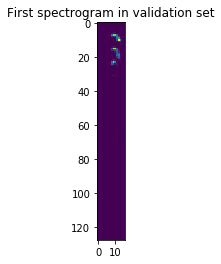

In [6]:
dummy = librosa.feature.melspectrogram(x_val[0], sr=8000)  # get shape of one spectrogram
print('dummy shape', dummy.shape)
# make mel spectrograms for x validation
x_val_mel = np.zeros(shape=(len(x_val), *dummy.shape))

for i in range(len(x_val)):
  x_val_mel[i] = librosa.feature.melspectrogram(x_val[i], sr=8000)

  if (i % 10 == 0) or (i == len(x_val)-1):
    done = int((i+1) * 80 / len(x_val))
    progress_bar = 'Progress ['
    progress_bar += 'o' * done
    progress_bar += '.' * (80 - done)
    progress_bar += ']'

    print('\r' + progress_bar, end='')

print('\nValidation x shape:', x_val_mel.shape)
plt.imshow(x_val_mel[0])
plt.title('First spectrogram in validation set')
plt.show()

np.save(mel_path + '/x_val.npy', x_val_mel)
np.save(mel_path + '/y_val.npy', y_val)

Progress [oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo]
Test x shape: (7000, 128, 16)


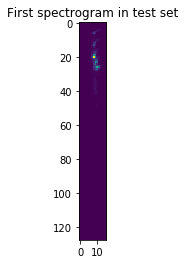

In [7]:
# make mel spectrograms for x test
x_test_mel = np.zeros(shape=(len(x_test), *dummy.shape))

for i in range(len(x_test)):
  x_test_mel[i] = librosa.feature.melspectrogram(x_test[i], sr=8000)

  if (i % 10 == 0) or (i == len(x_test)-1):
    done = int((i+1) * 80 / len(x_test))
    progress_bar = 'Progress ['
    progress_bar += 'o' * done
    progress_bar += '.' * (80 - done)
    progress_bar += ']'

    print('\r' + progress_bar, end='')

print('\nTest x shape:', x_test_mel.shape)
plt.imshow(x_test_mel[0])
plt.title('First spectrogram in test set')
plt.show()

np.save(mel_path + '/x_test.npy', x_test_mel)
np.save(mel_path + '/y_test.npy', y_test)

Progress [oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo]
Train x shape: (56721, 128, 16)


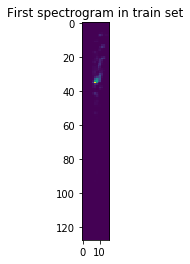

In [8]:
# make mel spectrograms for x train
x_train_mel = np.zeros(shape=(len(x_train), *dummy.shape))

for i in range(len(x_train)):
  x_train_mel[i] = librosa.feature.melspectrogram(x_train[i], sr=8000)

  if (i % 10 == 0) or (i == len(x_train)-1):
    done = int((i+1) * 80 / len(x_train))
    progress_bar = 'Progress ['
    progress_bar += 'o' * done
    progress_bar += '.' * (80 - done)
    progress_bar += ']'

    print('\r' + progress_bar, end='')

print('\nTrain x shape:', x_train_mel.shape)
plt.imshow(x_train_mel[0])
plt.title('First spectrogram in train set')
plt.show()

np.save(mel_path + '/x_train.npy', x_train_mel)
np.save(mel_path + '/y_train.npy', y_train)

In [0]:
x_val_mel, y_val_mel = np.load(mel_path + '/x_val.npy'), np.load(mel_path + '/y_val.npy')
x_val_mel = np.reshape(x_val_mel, (*x_val_mel.shape, 1))  # add singleton dimension
print(f"Shapes: x_val{x_val_mel.shape}, y_val{y_val_mel.shape}")

Shapes: x_val(1000, 128, 16, 1), y_val(1000,)


In [0]:
x_train_mel, y_train_mel = np.load(mel_path + '/x_train.npy'), np.load(mel_path + '/y_train.npy')
x_train_mel = np.reshape(x_train_mel, (*x_train_mel.shape, 1))  # add singleton dimension
print(f"Shapes: x_train{x_train_mel.shape}, y_train{y_train_mel.shape}")

x_test_mel, y_test_mel = np.load(mel_path + '/x_test.npy'), np.load(mel_path + '/y_test.npy')
x_test_mel = np.reshape(x_test_mel, (*x_test_mel.shape, 1))  # add singleton dimension
print(f"Shapes: x_test{x_test_mel.shape}, y_test{y_test_mel.shape}")

Shapes: x_train(56721, 128, 16, 1), y_train(56721,)
Shapes: x_test(7000, 128, 16, 1), y_test(7000,)


In [0]:
'''
Simple convolutional neural network for training on mel spectrograms
'''
class MelSpeechConv(tf.keras.Model):
    def __init__(self, n_classes, 
                 init_conv_size=3, 
                 init_num_filters = 8,
                 regularization='dropout(0.3)', 
                 num_dense_units=(256, 128)):
        super(MelSpeechConv, self).__init__()
        self.layerlist = []
        self.layerlist.append(tf.keras.layers.Conv2D(filters=init_num_filters, 
                                                     kernel_size=(init_conv_size, 3), 
                                                     strides=1, padding='valid', 
                                                     activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))
        if 'dropout' in regularization:
          rate = float(regularization[regularization.find('(')+1:][:-1])
          self.layerlist.append(tf.keras.layers.Dropout(rate))
        elif 'norm' in regularization:
          self.layerlist.append(tf.keras.layers.BatchNormalization())
        
        self.layerlist.append(tf.keras.layers.Conv2D(filters=init_num_filters, 
                                                     kernel_size=(init_conv_size, 3), 
                                                     strides=1, padding='valid', 
                                                     activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))
        if 'dropout' in regularization:
          rate = float(regularization[regularization.find('(')+1:][:-1])
          self.layerlist.append(tf.keras.layers.Dropout(rate))
        elif 'norm' in regularization:
          self.layerlist.append(tf.keras.layers.BatchNormalization())
        
        self.layerlist.append(tf.keras.layers.Conv2D(filters=init_num_filters * 2, 
                                                     kernel_size=(init_conv_size, 3), 
                                                     strides=1, padding='valid', 
                                                     activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))
        if 'dropout' in regularization:
          rate = float(regularization[regularization.find('(')+1:][:-1])
          self.layerlist.append(tf.keras.layers.Dropout(rate))
        elif 'norm' in regularization:
          self.layerlist.append(tf.keras.layers.BatchNormalization())
        
        self.layerlist.append(tf.keras.layers.Conv2D(filters=init_num_filters * 4, 
                                                     kernel_size=(init_conv_size, 3), 
                                                     strides=1, padding='valid', 
                                                     activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))
        if 'dropout' in regularization:
          rate = float(regularization[regularization.find('(')+1:][:-1])
          self.layerlist.append(tf.keras.layers.Dropout(rate))
        elif 'norm' in regularization:
          self.layerlist.append(tf.keras.layers.BatchNormalization())
        
        self.layerlist.append(tf.keras.layers.Flatten())
        self.layerlist.append(tf.keras.layers.Dense(num_dense_units[0], activation=tf.nn.relu))
        if 'dropout' in regularization:
          rate = float(regularization[regularization.find('(')+1:][:-1])
          self.layerlist.append(tf.keras.layers.Dropout(rate))
        elif 'norm' in regularization:
          self.layerlist.append(tf.keras.layers.BatchNormalization())
        self.layerlist.append(tf.keras.layers.Dense(num_dense_units[1], activation=tf.nn.softmax))
        self.layerlist.append(tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax))
    
    def call(self, inputs):
        x = inputs
        
        for i in range(len(self.layerlist)-1):
          x = self.layerlist[i](x)
        
        return self.layerlist[-1](x)
    
    def build_graph(self, input_shape): 
        input_shape_nobatch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_nobatch)
        
        if not hasattr(self, 'call'):
            raise AttributeError("User should define 'call' method in sub-class model!")
        
        _ = self.call(inputs)
    


Network 1/36


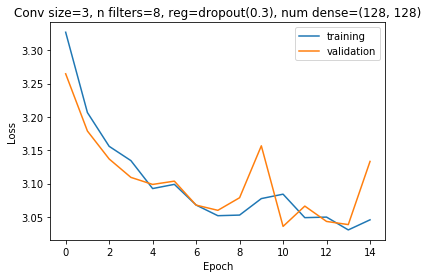

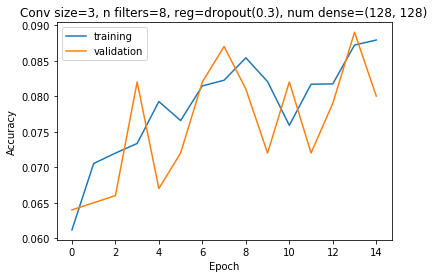

Training time: 76.55

Network 2/36


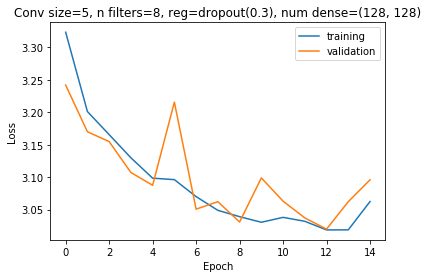

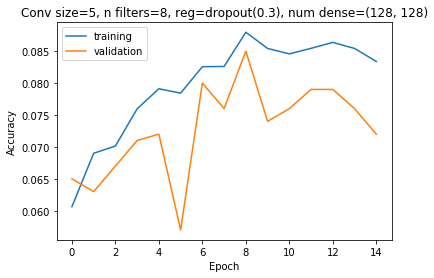

Training time: 78.96

Network 3/36


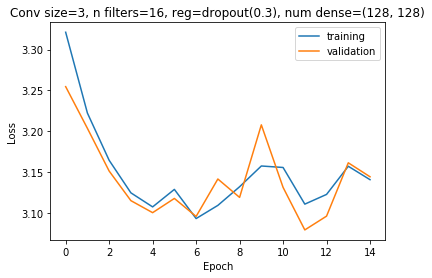

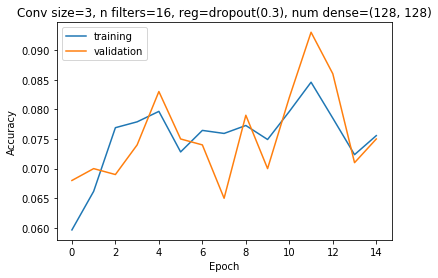

Training time: 115.09

Network 4/36


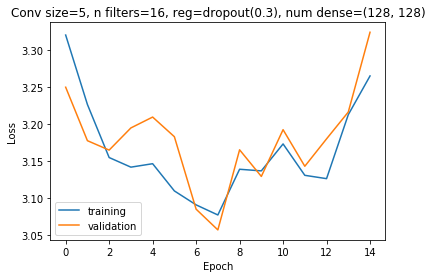

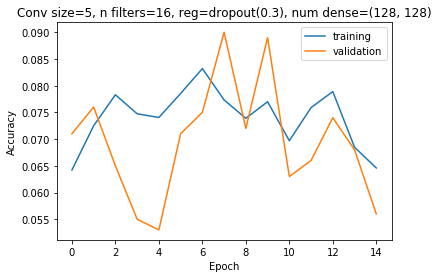

Training time: 119.85

Network 5/36


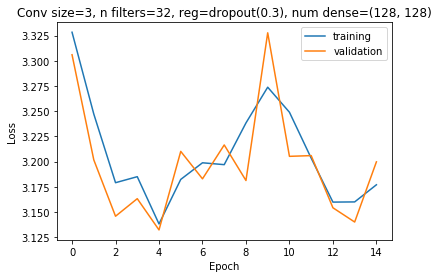

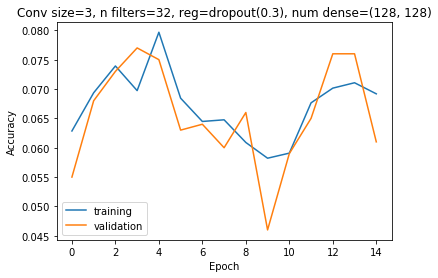

Training time: 179.12

Network 6/36


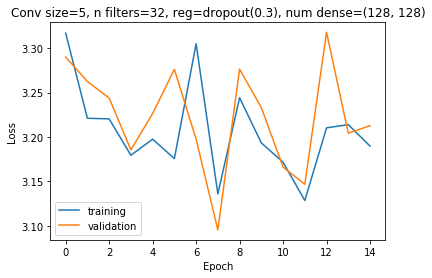

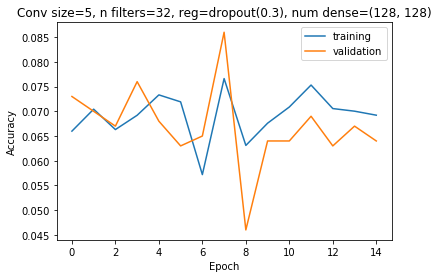

Training time: 216.88

Network 7/36


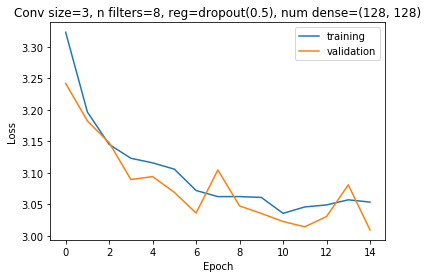

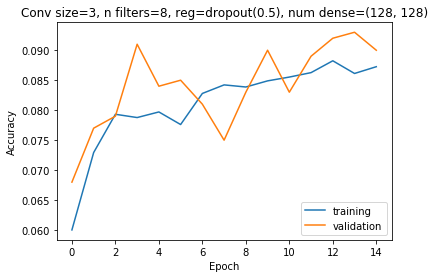

Training time: 75.74

Network 8/36


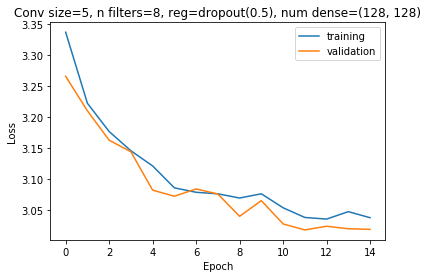

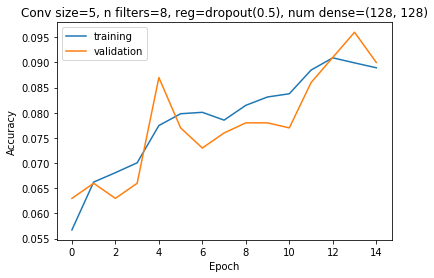

Training time: 79.21

Network 9/36


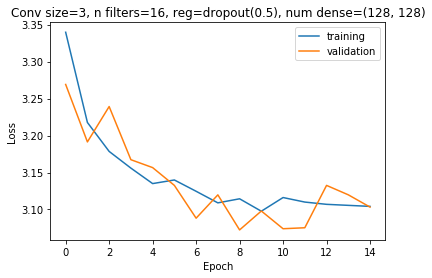

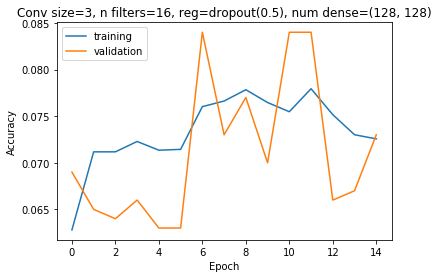

Training time: 114.09

Network 10/36


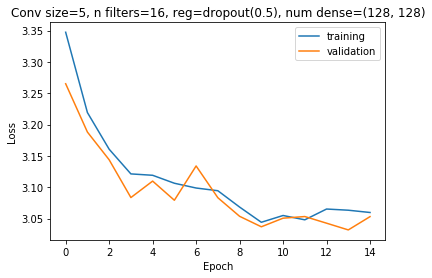

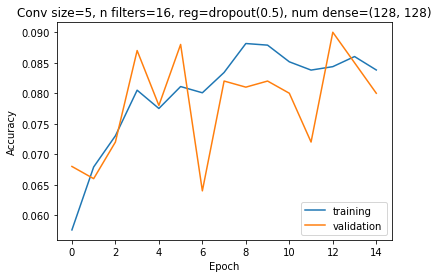

Training time: 119.39

Network 11/36


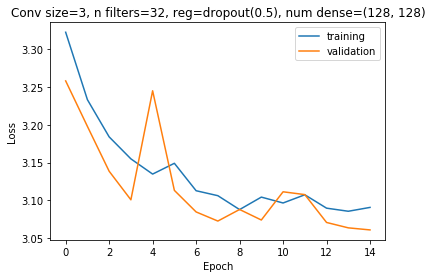

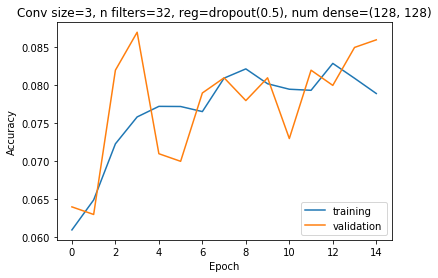

Training time: 177.85

Network 12/36


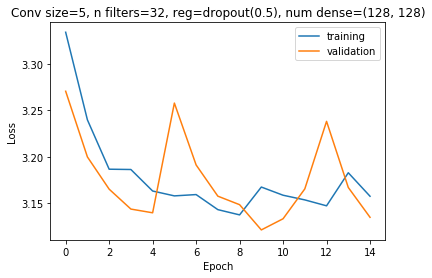

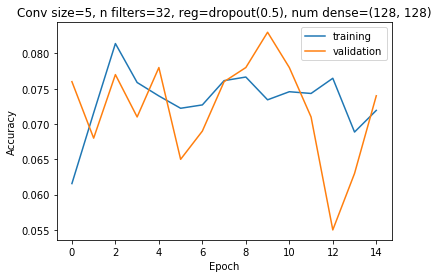

Training time: 216.30

Network 13/36


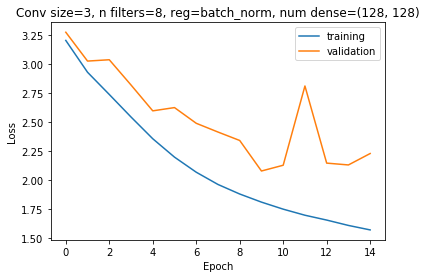

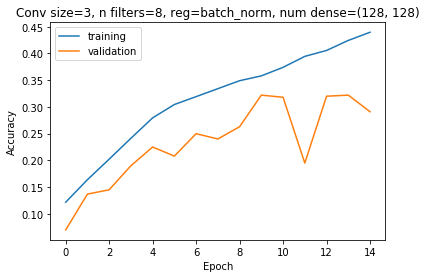

Training time: 79.49

Network 14/36


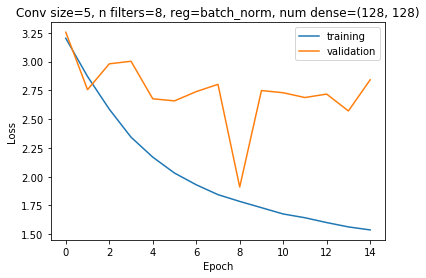

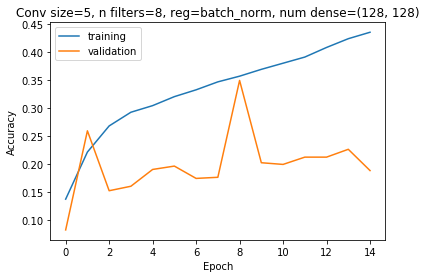

Training time: 82.87

Network 15/36


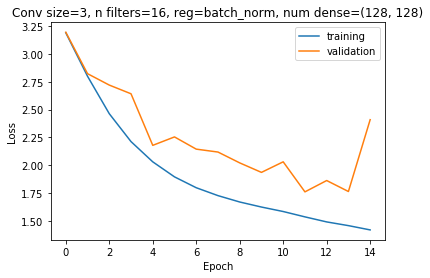

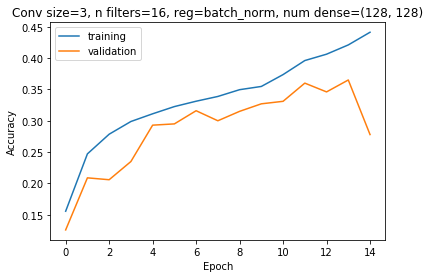

Training time: 115.70

Network 16/36


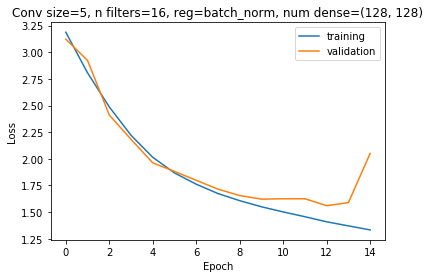

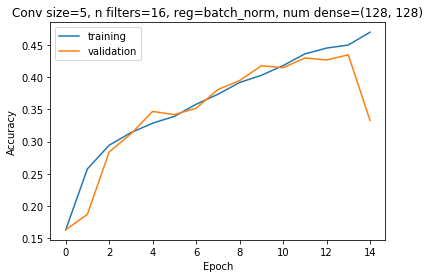

Training time: 120.56

Network 17/36


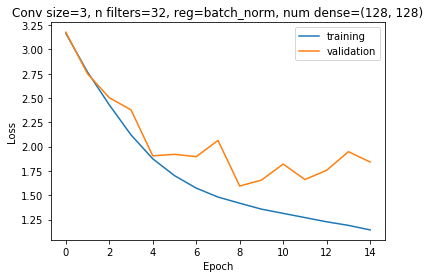

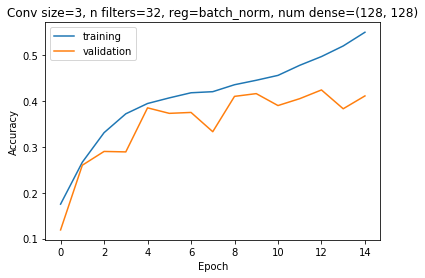

Training time: 177.36

Network 18/36


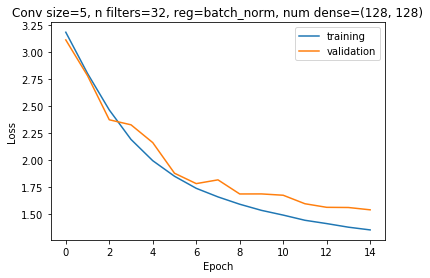

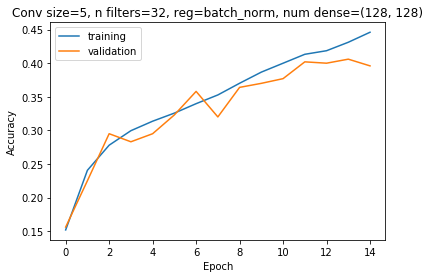

Training time: 220.85

Network 19/36


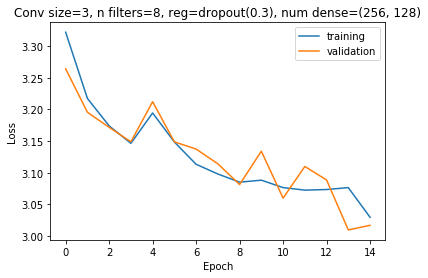

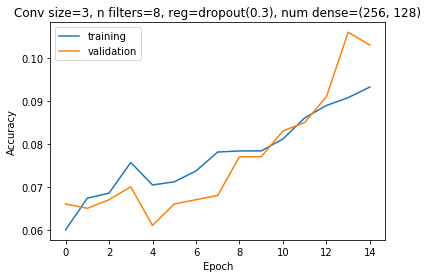

Training time: 76.81

Network 20/36


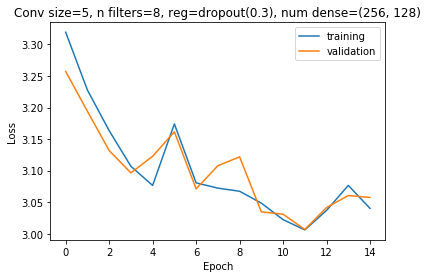

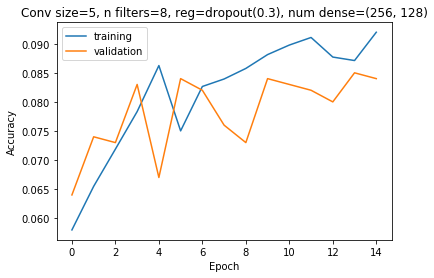

Training time: 79.31

Network 21/36


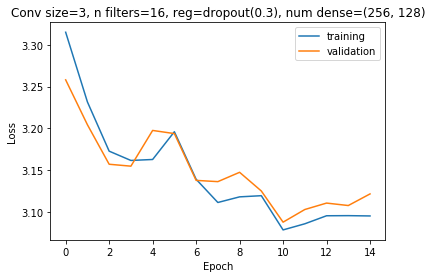

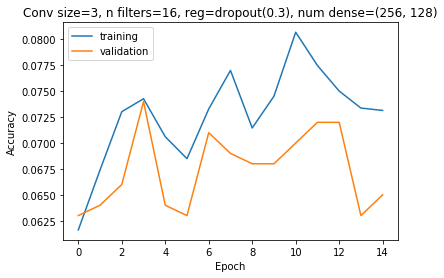

Training time: 116.76

Network 22/36


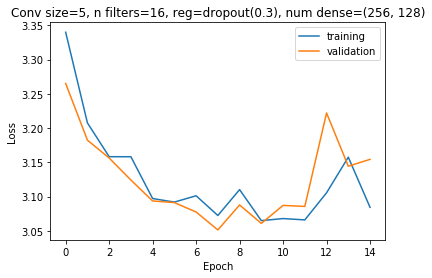

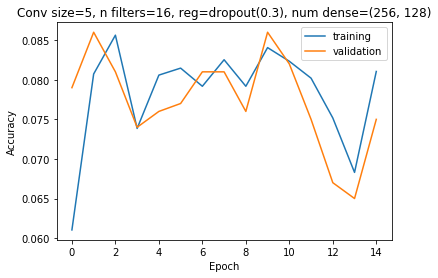

Training time: 120.63

Network 23/36


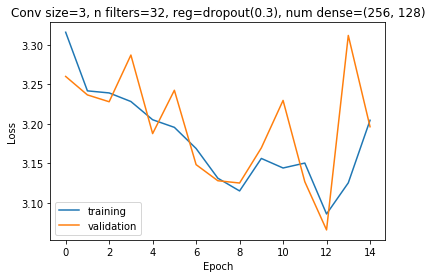

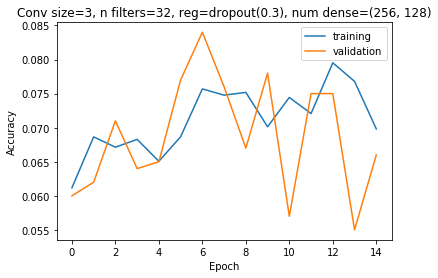

Training time: 185.53

Network 24/36


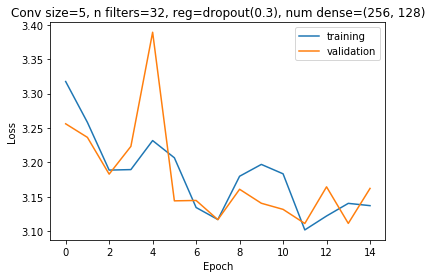

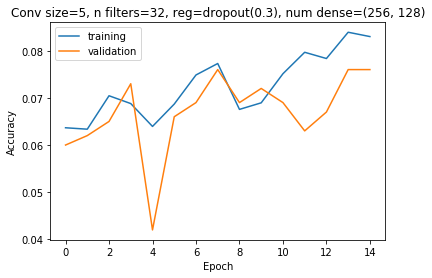

Training time: 220.35

Network 25/36


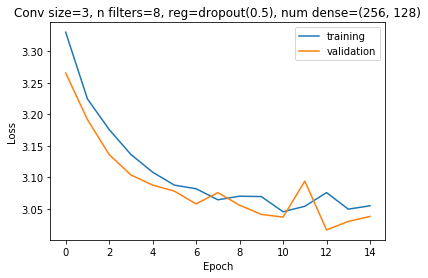

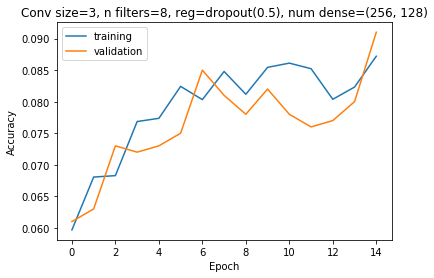

Training time: 77.27

Network 26/36


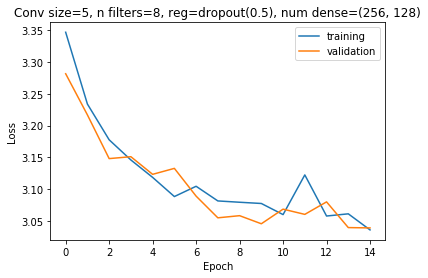

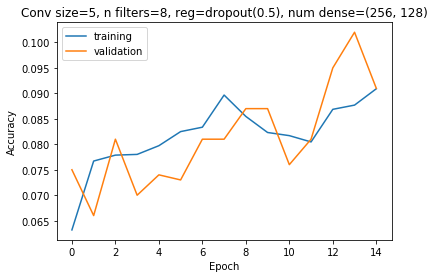

Training time: 79.94

Network 27/36


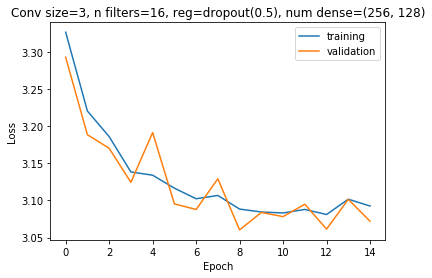

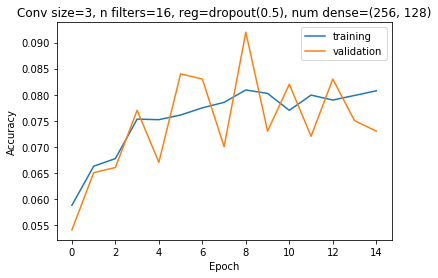

Training time: 117.16

Network 28/36


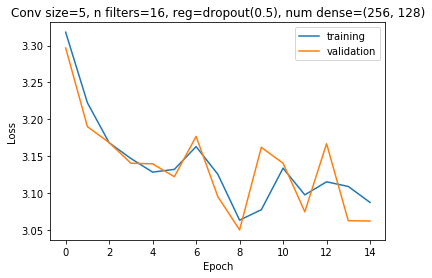

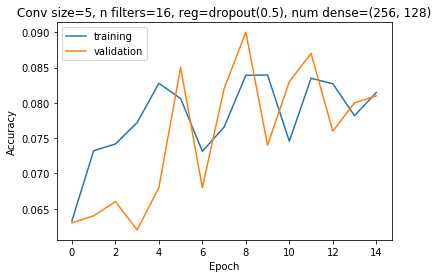

Training time: 122.92

Network 29/36


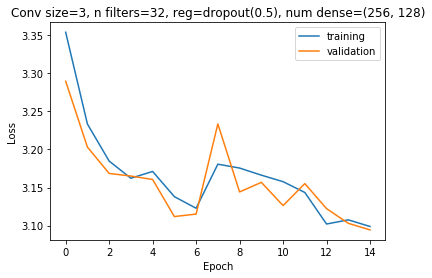

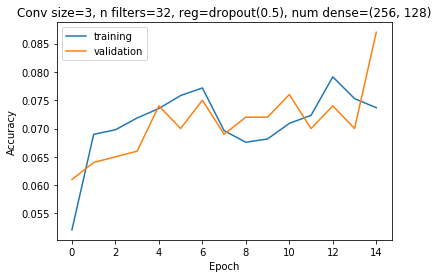

Training time: 185.00

Network 30/36


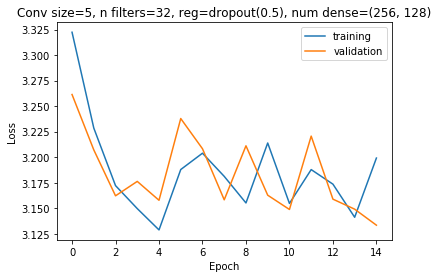

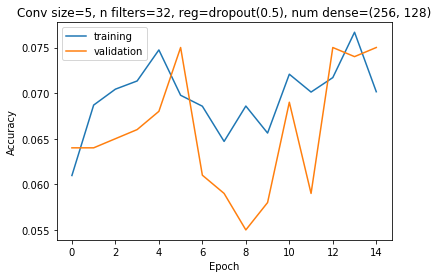

Training time: 221.32

Network 31/36


In [0]:
# perform grid search in order to find the best parameters for Mel Conv Speech
init_conv_sizes = [3, 5]
init_nums_filters = [8, 16, 32]
regularizations = ['dropout(0.3)', 'dropout(0.5)', 'batch_norm']
nums_dense = [(128, 128), (256, 128)]

results = []

counter = 0
for num_dense in nums_dense:
  for regularization in regularizations:
    for num_filters in init_nums_filters:
      for init_conv_size in init_conv_sizes:
          counter += 1
          print(f'\nNetwork {counter}/36')

          mel_conv = MelSpeechConv(n_classes=30, init_conv_size=init_conv_size, init_num_filters=num_filters, 
                                regularization=regularization, num_dense_units=num_dense)
          mel_conv.build_graph(x_val_mel.shape)
          mel_conv.compile(optimizer='adam', metrics=['accuracy'], loss=['sparse_categorical_crossentropy'])

          init_time = time.time()
          history=mel_conv.fit(x_train_mel, y_train_mel ,epochs=15, batch_size=128, validation_data=(x_val_mel,y_val_mel),
                               verbose=0)
          train_time = time.time() - init_time

          # compute testing accuracy as the mean accuracy of last 3 epochs
          final_acc = np.mean(np.asarray(history.history['val_accuracy'][-3:]))

          # plot loss
          plt.plot(history.history['loss'], label='training')
          plt.plot(history.history['val_loss'], label='validation')
          plt.title(f'Conv size={init_conv_size}, n filters={num_filters}, reg={regularization}, num dense={num_dense}')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.legend()
          plt.show()

          # plot accuracy
          plt.plot(history.history['accuracy'], label='training')
          plt.plot(history.history['val_accuracy'], label='validation')
          plt.title(f'Conv size={init_conv_size}, n filters={num_filters}, reg={regularization}, num dense={num_dense}')
          plt.xlabel('Epoch')
          plt.ylabel('Accuracy')
          plt.legend()
          plt.show()

          print(f'Training time: {train_time:.2f}')

          results.append((final_acc, init_conv_size, num_filters, regularization, num_dense, train_time))

results.sort(key=lambda tup: tup[0])
print('Top 5 best networks')
for i in range(5):
  network = results[len(results) - 1 - i]

  print(f'Final accuracy={network[0]}, conv size={network[1]}, n filters={network[2]}, reg={network[3]}, '+
        f'num dense={network[4]}, train time={network[5]:.2f}s')

In [0]:
'''
Revised model of MelSpeechConv. Only uses BatchNormalization (and not Dropout) on early layers.
'''
class MelSpeechConv(tf.keras.Model):
    def __init__(self, n_classes, 
                 init_conv_size=3, 
                 init_num_filters = 8,
                 dropout_rate=0.3, 
                 num_dense_units=(256, 128)):
        super(MelSpeechConv, self).__init__()
        self.layerlist = []
        self.layerlist.append(tf.keras.layers.Conv2D(filters=init_num_filters, 
                                                     kernel_size=(init_conv_size, 3), 
                                                     strides=1, padding='valid', 
                                                     activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))
        self.layerlist.append(tf.keras.layers.BatchNormalization())
        
        self.layerlist.append(tf.keras.layers.Conv2D(filters=init_num_filters, 
                                                     kernel_size=(init_conv_size, 3), 
                                                     strides=1, padding='valid', 
                                                     activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))
        self.layerlist.append(tf.keras.layers.BatchNormalization())
        
        self.layerlist.append(tf.keras.layers.Conv2D(filters=init_num_filters * 2, 
                                                     kernel_size=(init_conv_size, 3), 
                                                     strides=1, padding='valid', 
                                                     activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))
        self.layerlist.append(tf.keras.layers.BatchNormalization())
        
        self.layerlist.append(tf.keras.layers.Conv2D(filters=init_num_filters * 4, 
                                                     kernel_size=(init_conv_size, 3), 
                                                     strides=1, padding='valid', 
                                                     activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))
        self.layerlist.append(tf.keras.layers.Dropout(dropout_rate))
        
        self.layerlist.append(tf.keras.layers.Flatten())
        self.layerlist.append(tf.keras.layers.Dense(num_dense_units[0], activation=tf.nn.relu))
        self.layerlist.append(tf.keras.layers.Dropout(dropout_rate))
        self.layerlist.append(tf.keras.layers.Dense(num_dense_units[1], activation=tf.nn.softmax))
        self.layerlist.append(tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax))
    
    def call(self, inputs):
        x = inputs
        
        for i in range(len(self.layerlist)-1):
            x = self.layerlist[i](x)
        
        return self.layerlist[-1](x)
    
    def build_graph(self, input_shape): 
        input_shape_nobatch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_nobatch)
        
        if not hasattr(self, 'call'):
            raise AttributeError("User should define 'call' method in sub-class model!")
        
        _ = self.call(inputs)
    

In [0]:
# create model with optimal params
melconv = MelSpeechConv(n_classes=30, init_conv_size=5, init_num_filters=16, dropout_rate=0.3, num_dense_units=(128, 64))
melconv.build_graph(x_val_mel.shape)
melconv.compile(optimizer='adam', metrics=['accuracy'], loss=['sparse_categorical_crossentropy'])
melconv.summary()

Model: "mel_speech_conv_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 14, 16)       256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 14, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 14, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 12, 16)        3856      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 12, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 29, 12, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 10, 32)  

Train on 56721 samples, validate on 1000 samples
Epoch 1/120
56721/56721 [==============================] - 5s 84us/sample - loss: 3.2653 - accuracy: 0.0935 - val_loss: 3.1966 - val_accuracy: 0.0960
Epoch 2/120
56721/56721 [==============================] - 4s 63us/sample - loss: 3.0650 - accuracy: 0.1139 - val_loss: 3.0904 - val_accuracy: 0.0990
Epoch 3/120
56721/56721 [==============================] - 4s 63us/sample - loss: 2.9434 - accuracy: 0.1242 - val_loss: 3.0615 - val_accuracy: 0.0940
Epoch 4/120
56721/56721 [==============================] - 4s 64us/sample - loss: 2.8543 - accuracy: 0.1323 - val_loss: 2.9639 - val_accuracy: 0.1070
Epoch 5/120
56721/56721 [==============================] - 4s 64us/sample - loss: 2.7789 - accuracy: 0.1379 - val_loss: 2.7897 - val_accuracy: 0.1320
Epoch 6/120
56721/56721 [==============================] - 4s 64us/sample - loss: 2.7067 - accuracy: 0.1507 - val_loss: 2.6766 - val_accuracy: 0.1530
Epoch 7/120
56721/56721 [==========================

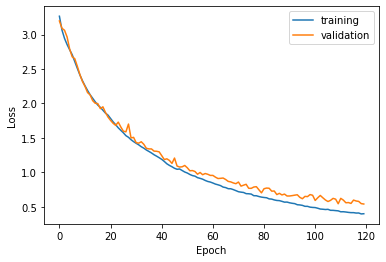

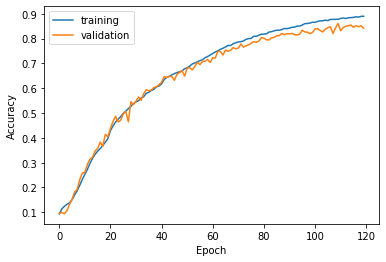

In [0]:
save_model_path = 'drive/My Drive/Speech/trained'
callbacks = [tf.keras.callbacks.ModelCheckpoint(save_model_path + '/melconv2',
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                save_weights_only=True)]

history=melconv.fit(x_train_mel, y_train_mel ,epochs=120, batch_size=128, validation_data=(x_val_mel,y_val_mel),
                    callbacks=callbacks)

# plot loss
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# load best weights and evaluate on validation set
melconv = MelSpeechConv(n_classes=30, init_conv_size=5, init_num_filters=16, dropout_rate=0.3, num_dense_units=(128, 64))
melconv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
melconv.load_weights(save_model_path + '/melconv2')

print('Validation accuracy:', melconv.evaluate(x_val_mel, y_val_mel, verbose=0)[1])

Validation accuracy: 0.861


In [0]:
#--------------------------------------------------------------------------------------------------------------------------------
'''Train LSTM for speech command classification'''

In [0]:
# (default runtime, using tensorflow 1)

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import librosa
import IPython.display as ipd
from scipy.io import wavfile 

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization
from keras.preprocessing import sequence
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Reshape
from keras.layers import Activation
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
# load data
mel_path = 'drive/My Drive/Speech/tf_speech_mel_new'

x_train_mel, y_train_mel = np.load(mel_path + '/x_train.npy'), np.load(mel_path + '/y_train.npy')
x_train_mel = np.reshape(x_train_mel, (*x_train_mel.shape, 1))  # add singleton dimension
print(f"Shapes: x_train{x_train_mel.shape}, y_train{y_train_mel.shape}")

x_test_mel, y_test_mel = np.load(mel_path + '/x_test.npy'), np.load(mel_path + '/y_test.npy')
x_test_mel = np.reshape(x_test_mel, (*x_test_mel.shape, 1))
print(f"Shapes: x_test{x_test_mel.shape}, y_test{y_test_mel.shape}")

x_val_mel, y_val_mel = np.load(mel_path + '/x_val.npy'), np.load(mel_path + '/y_val.npy')
x_val_mel = np.reshape(x_val_mel, (*x_val_mel.shape, 1))
print(f"Shapes: x_val{x_val_mel.shape}, y_val{y_val_mel.shape}")

Shapes: x_train(56721, 128, 16, 1), y_train(56721,)
Shapes: x_test(7000, 128, 16, 1), y_test(7000,)
Shapes: x_val(1000, 128, 16, 1), y_val(1000,)


In [0]:
# reshape validation data for LSTM
batch, n_mels, length, channels = x_val_mel.shape
x_val = np.reshape(x_val_mel, newshape=(batch, length, n_mels, channels))
print('New val shape:', x_val.shape)

# reshape test data for LSTM
batch, n_mels, length, channels = x_test_mel.shape
x_test = np.reshape(x_test_mel, newshape=(batch, length, n_mels, channels))
print('New test shape:', x_test.shape)

# reshape train data for LSTM
batch, n_mels, length, channels = x_train_mel.shape
x_train = np.reshape(x_train_mel, newshape=(batch, length, n_mels, channels))
print('New train shape:', x_train.shape)

New val shape: (1000, 16, 128, 1)
New test shape: (7000, 16, 128, 1)
New train shape: (56721, 16, 128, 1)


In [0]:
# define CNN LSTM for speech command recognition
def lstm_speech(input_shape):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape, filters=16, kernel_size=(3,5), padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
  model.add(BatchNormalization())
  
  model.add(Conv2D(filters=16, kernel_size=(3,5), padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=(3,5), padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(3,5), padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
  model.add(Dropout(rate=0.3))

  model.add(Reshape((8, 4*64)))

  model.add(LSTM(100, input_shape=(16, 112*16)))
  model.add(Dense(30, activation='softmax'))

  return model

In [0]:
model = lstm_speech(x_val[0].shape)
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 124, 16)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 62, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 62, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 58, 16)        3856      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 29, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 29, 16)        64  

In [0]:
model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train_mel, batch_size=256, epochs=30, validation_data=(x_val, y_val_mel))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 56721 samples, validate on 1000 samples
Epoch 1/30
56721/56721 [==============================] - 18s 326us/step - loss: 2.7363 - acc: 0.1876 - val_loss: 2.8568 - val_acc: 0.1510
Epoch 2/30
56721/56721 [==============================] - 13s 226us/step - loss: 1.8200 - acc: 0.4399 - val_loss: 2.4428 - val_acc: 0.2990
Epoch 3/30
56721/56721 [==============================] - 13s 223us/step - loss: 1.3011 - acc: 0.6015 - val_loss: 1.5644 - val_acc: 0.5190
Epoch 4/30
56721/56721 [==============================] - 13s 225us/step - loss: 1.0591 - acc: 0.6753 - val_loss: 1.1524 - val_acc: 0.6200
Epoch 5/30
56721/56721 [==============================] - 13s 224us/step - loss: 0.9156 - acc: 0.7193 - val_loss: 1.0085 - val_acc: 0.6720
Epoch 6/30
56721/56721 [==============================] - 13s 227us/step - loss: 0.8216 - acc: 0.7464 - val_loss: 0.8731 - val_acc: 0.7320
Epoch 7/30
56721/56

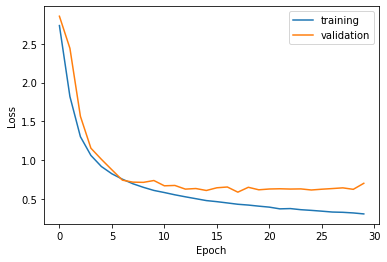

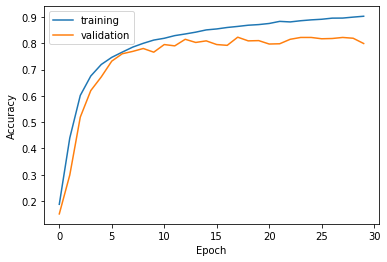

In [0]:
# plot loss
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
print('Final testing accuracy:', model.evaluate(x_test, y_test_mel, verbose=0)[1])

Final testing accuracy: 0.8354285714285714
